In [1]:
# Import dependencies
import torch
import torch.nn.functional as F

import phog.pcfg_models as pcfg_models
import phog.pcfg_loader as loader
import source as source


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [2]:
# Import our data yielder
data_folder = 'training'
loader_params = {
    'batch_size': 1,
    'shuffle': True,
    'only_inputs': True,
    'print_steps': True,
    'moves_per_step': 1,
    'max_steps': 1,
    'p_use_base': 0.25,
}
data_yielder = loader.get_pcfg_datayielder(data_folder, loader_params)
# embedding_model = source.embedding.load_ViT(filename='vit_11-21-24_400k_v1.pth', device=device)

pcfg_filename = 'pcfg_encoder_20241203_165657.pth'
pcfg_encoder = pcfg_models.PCFG_Encoder.load_model(f"phog/trained_pcfg_models/{pcfg_filename}", print_statements=True, device=device)

C:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\phog\pcfg_models\pcfg_encoder.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Vision Transformer instantiated with 84,064 parameters using Sinusoidal encodings.
PCFG encoder instantiated with 52,288 parameters.


In [3]:
def embed_input(input, pcfg_encoder, use_grads, device):
    x = torch.zeros((len(input), pcfg_encoder.model_params['n_embd']), device=device)
    special_tokens = pcfg_encoder.get_special_tokens(device)   # cls_dsl, cls_obj, pad, sep
    
    try:
        first_pad = input[:16].index('<PAD>')
    except ValueError:
        first_pad = 16
    
    for i, obj in enumerate(input):
        if obj == "<PAD>":
            x[i, :] = special_tokens[2, :]
        elif obj == "<SEP>":
            x[i, :] = special_tokens[3, :]
        elif isinstance(obj, source.ARC_Object):
            obj.set_embedding(pcfg_encoder.embedding_model, use_grads=use_grads)
            x[i, :] = obj.embedding.to(device)
        else:
            raise NameError("Input contains object that is not '<PAD>', '<SEP>', or an ARC_Object.")
    x = torch.cat((special_tokens[:2, :], x), dim=0)
    return x, first_pad

Problem ID: ae4f1146-input-0, [1/1]
Transformation applied: draw_line on objects.
Input:


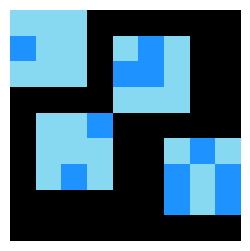

Output:


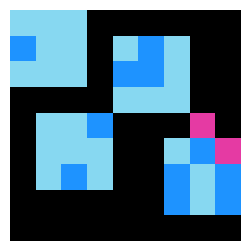

      draw_line: 0.194
 copy_translate: 0.148
          color: 0.113
      translate: 0.110
    single_copy: 0.103
        recolor: 0.101
         rotate: 0.094
           flip: 0.080
         delete: 0.058

Problem ID: b527c5c6-input-1, [1/1]
Transformation applied: copy_translate on objects.
Input:


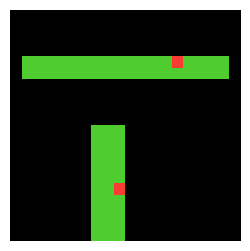

Output:


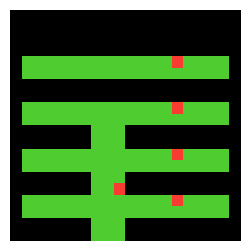

      draw_line: 0.192
 copy_translate: 0.145
          color: 0.113
      translate: 0.109
        recolor: 0.103
    single_copy: 0.101
         rotate: 0.098
           flip: 0.084
         delete: 0.055

Problem ID: e26a3af2-input-0, [1/1]
Transformation applied: single_copy on objects.
Input:


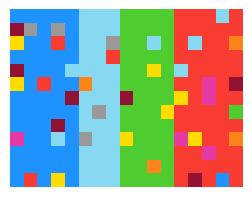

Output:


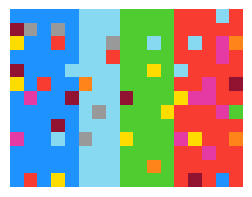

      draw_line: 0.173
 copy_translate: 0.155
    single_copy: 0.116
      translate: 0.113
          color: 0.110
        recolor: 0.096
         delete: 0.087
         rotate: 0.081
           flip: 0.067

Problem ID: e8593010-input-0, [1/1]
Transformation applied: flip on objects.
Input:


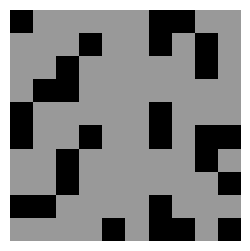

Output:


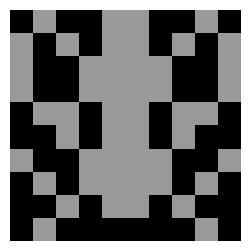

      draw_line: 0.191
 copy_translate: 0.142
          color: 0.113
      translate: 0.109
        recolor: 0.104
         rotate: 0.100
    single_copy: 0.099
           flip: 0.087
         delete: 0.054

Problem ID: 94f9d214-input-0, [1/1]
Transformation applied: rotate on base.
Input:


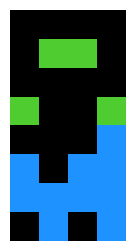

Output:


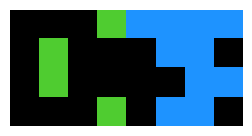

      draw_line: 0.194
 copy_translate: 0.147
          color: 0.112
      translate: 0.110
    single_copy: 0.102
        recolor: 0.101
         rotate: 0.095
           flip: 0.081
         delete: 0.057



In [5]:
print_samples = loader_params['print_steps']
ftoi = pcfg_encoder.dsl_mapping
itof = {value: key.__name__ for key, value in ftoi.items()}

for i in range(5):
    try:
        key, input, label, obj_indices = next(data_yielder)
    except Exception as e:
        print(f"Exception raised: {e}")
        continue
    
    x, first_pad = embed_input(input, pcfg_encoder, use_grads=not pcfg_encoder.freeze_emb_model, device=device)
    dsl_cls, obj_att = pcfg_encoder(x)
    obj_att = obj_att[2:first_pad + 2]

    dsl_cls = F.softmax(dsl_cls, dim=-1).to('cpu').tolist()
    obj_att = F.softmax(obj_att, dim=-1).to('cpu')

    dsl_labels = [(val, itof[i]) for i, val in enumerate(dsl_cls)]
    dsl_labels.sort(reverse=True)
    for v, f in dsl_labels:
        print(f"{f:>15}: {v:.3f}")
    

    print(f"")